# Single Model Training

This notebook is to enable model training for a single model using the specified parameters in config.yaml.


In [39]:
# Import required libraries
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)
from src.pipelines.xgboost.train_single_model import main

## 1. Run Model

In [40]:
features = ["fea_is_foods", "fea_is_household", "fea_is_hobbies", "fea_dept_number"]
trained_model = main(features = features)

INFO:src.pipelines.xgboost.train_single_model:
        XGBoost Model Training Pipeline is starting...
        
INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 148964 rows from table: walmart_master_table
INFO:src.pipelines.xgboost.train_single_model:Filtering outliers ...
INFO:src.pipelines.xgboost.train_single_model:Training model...
INFO:src.core.models.xgboost:
            Training XGBoost Model...
            


[0]	validation_0-rmse:2.12455	validation_1-rmse:1.55640
[1]	validation_0-rmse:2.11793	validation_1-rmse:1.54352
[2]	validation_0-rmse:2.11467	validation_1-rmse:1.53643
[3]	validation_0-rmse:2.11307	validation_1-rmse:1.53243
[4]	validation_0-rmse:2.11229	validation_1-rmse:1.53010
[5]	validation_0-rmse:2.11191	validation_1-rmse:1.52870
[6]	validation_0-rmse:2.11172	validation_1-rmse:1.52784
[7]	validation_0-rmse:2.11163	validation_1-rmse:1.52729
[8]	validation_0-rmse:2.11158	validation_1-rmse:1.52694
[9]	validation_0-rmse:2.11156	validation_1-rmse:1.52670
[10]	validation_0-rmse:2.11155	validation_1-rmse:1.52654
[11]	validation_0-rmse:2.11154	validation_1-rmse:1.52644
[12]	validation_0-rmse:2.11154	validation_1-rmse:1.52636
[13]	validation_0-rmse:2.11154	validation_1-rmse:1.52631
[14]	validation_0-rmse:2.11154	validation_1-rmse:1.52628
[15]	validation_0-rmse:2.11154	validation_1-rmse:1.52625
[16]	validation_0-rmse:2.11154	validation_1-rmse:1.52624
[17]	validation_0-rmse:2.11154	validation

INFO:src.core.models.xgboost:Model saved to /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260123_121944/model_0.joblib
INFO:src.core.models.xgboost:
            Model Training Pipeline completed successfully!
            Run ID: /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260123_121944
            Artifacts saved to: /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260123_121944
            


## 2. Compare metrics with Benchmark

1. Compare Metrics (MdAPE, MdAE) with benchmark in total and accross validation sets of interest

In [41]:
# Now you can import from core if needed
from src.core.clients.bigquery import BigQueryClient
from src.core.config_loader import ConfigLoader

bq_client = BigQueryClient()
config_loader = ConfigLoader()

sales_query = f"""
    SELECT 
        tgt.ctx_date_month,
        tgt.ctx_cat_id, 
        tgt.ctx_dept_id, 
        tgt.ctx_item_id,
        tgt.tgt_benchmark,
        tgt.tgt_monthly_sales_sum_3_next_months,
        {','.join(features)}
    FROM `porygon-pipelines.walmart_training_tables.walmart_master_table` tgt
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND is_stockout_tgt = 0
"""


# Extract data
df = bq_client.load_from_query(sales_query)


INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 148964 rows from custom query.


In [42]:
df.columns

Index(['ctx_date_month', 'ctx_cat_id', 'ctx_dept_id', 'ctx_item_id',
       'tgt_benchmark', 'tgt_monthly_sales_sum_3_next_months', 'fea_is_foods',
       'fea_is_household', 'fea_is_hobbies', 'fea_dept_number'],
      dtype='object')

In [43]:
from src.core.transformations.transformations import apply_log_normal_transformation

df = apply_log_normal_transformation(df, target_col ="tgt_benchmark")
df = apply_log_normal_transformation(df)

In [44]:
from src.core.transformations.transformations import split_dataset
from sklearn.metrics import root_mean_squared_error

# Split dataframes
training_df, validation_df = split_dataset(loaded_df= df)
benchmark = root_mean_squared_error(validation_df[config_loader.target_col], validation_df["tgt_benchmark"])


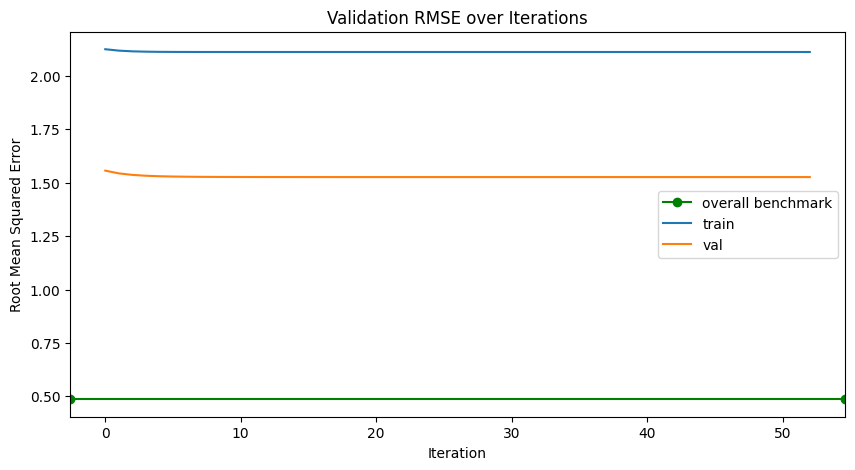

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

evals_result = trained_model.model.evals_result()
poisson_nloglik0 = evals_result['validation_0']['rmse']
poisson_nloglik1 = evals_result['validation_1']['rmse']

plt.figure(figsize=(10, 5))
plt.axhline(y=benchmark, color="green", marker="o", label="overall benchmark")
sns.lineplot(x=range(len(poisson_nloglik0)), y=poisson_nloglik0, label="train")
sns.lineplot(x=range(len(poisson_nloglik1)), y=poisson_nloglik1, label="val")
plt.xlabel('Iteration')
plt.ylabel('Root Mean Squared Error')
plt.title('Validation RMSE over Iterations')
plt.show()

## 6. Evaluate Residuals

In [57]:
predictions = trained_model.model.predict(validation_df[features])
residuals = validation_df[config_loader.target_col] - predictions
bench_residuals = validation_df[config_loader.target_col] - validation_df["tgt_benchmark"]

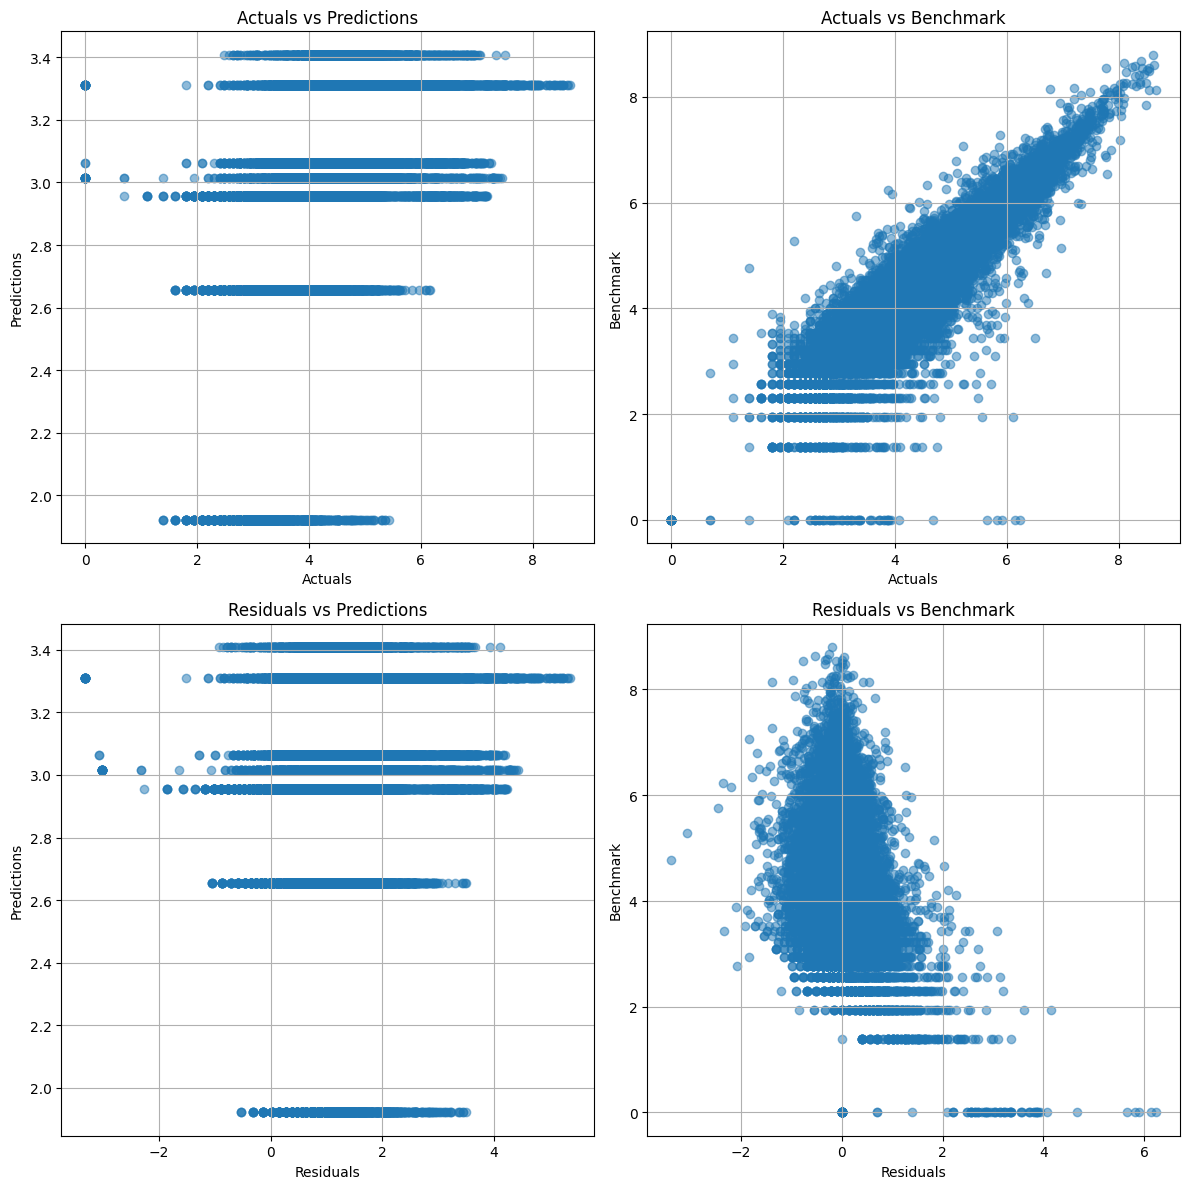

In [59]:
fig, axs = plt.subplots(2,2, figsize=(12,12))

# Actuals vs Predictions
axs[0,0].scatter(validation_df[config_loader.target_col], predictions, alpha = 0.5)
axs[0,0].set_xlabel("Actuals")
axs[0,0].set_ylabel("Predictions")
axs[0,0].set_title("Actuals vs Predictions")
axs[0,0].grid(True)

# Actuals vs Benchmark
axs[0,1].scatter(validation_df[config_loader.target_col], validation_df["tgt_benchmark"], alpha = 0.5)
axs[0,1].set_xlabel("Actuals")
axs[0,1].set_ylabel("Benchmark")
axs[0,1].set_title("Actuals vs Benchmark")
axs[0,1].grid(True)

# Residuals vs Predictions
axs[1,0].scatter(residuals, predictions, alpha = 0.5)
axs[1,0].set_xlabel("Residuals")
axs[1,0].set_ylabel("Predictions")
axs[1,0].set_title("Residuals vs Predictions")
axs[1,0].grid(True)

# Residuals vs Benchamrk
axs[1,1].scatter(bench_residuals, validation_df["tgt_benchmark"], alpha = 0.5)
axs[1,1].set_xlabel("Residuals")
axs[1,1].set_ylabel("Benchmark")
axs[1,1].set_title("Residuals vs Benchmark")
axs[1,1].grid(True)

plt.tight_layout()
plt.show()

## 8. Feature Importance

In [66]:
trained_model.feature_importance["feature"].to_list()

['fea_dept_number', 'fea_is_household', 'fea_is_foods', 'fea_is_hobbies']

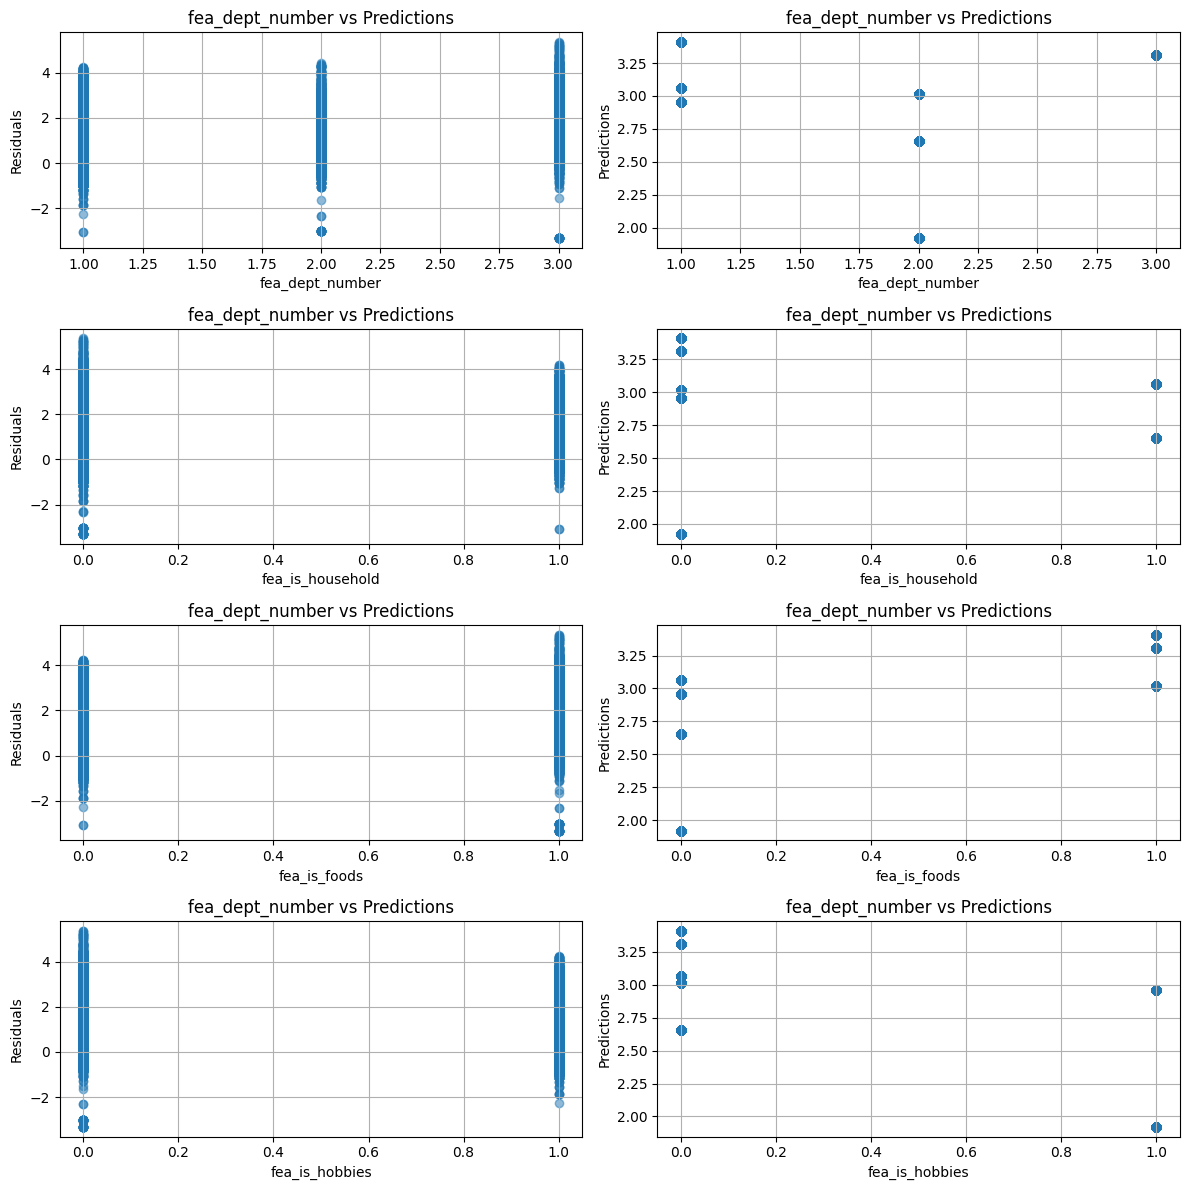

In [70]:
fig, axs = plt.subplots(len((trained_model.feature_importance["feature"].to_list())),2, figsize=(12,12))

for ax_index, feature in zip(range(len((trained_model.feature_importance["feature"].to_list()))), trained_model.feature_importance["feature"].to_list()):
    # Feature vs Residual
    axs[ax_index, 0].scatter(validation_df[feature], residuals, alpha = 0.5)
    axs[ax_index, 0].set_xlabel(feature)
    axs[ax_index, 0].set_ylabel("Residuals")
    axs[ax_index, 0].set_title("fea_dept_number vs Predictions")
    axs[ax_index, 0].grid(True)

    # Feature vs Prediction
    axs[ax_index, 1].scatter(validation_df[feature], predictions, alpha = 0.5)
    axs[ax_index, 1].set_xlabel(feature)
    axs[ax_index, 1].set_ylabel("Predictions")
    axs[ax_index, 1].set_title("fea_dept_number vs Predictions")
    axs[ax_index, 1].grid(True)

plt.tight_layout()